# Week 2 — KRAS Co-mutation Context and Tumor Immune Activity (TCGA LUAD)

**Goal:**
Determine whether co-mutations (TP53, STK11, KEAP1) explain differences in tumor immune activity among KRAS-mutant lung adenocarcinoma samples.

**Background:**
Previous studies suggest that KRAS subtype alone may not strongly determine tumor immunogenicity in human patients. Instead, co-occurring mutations are known to reshape the tumor immune microenvironment.

**Dataset:**
TCGA LUAD RNA-seq TPM + somatic mutation data

**Author:** Siya Singh


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
maf = pd.read_csv("../data/mc3_LUAD.txt.gz", sep="\t", low_memory=False)
expr = pd.read_csv("../data/TCGA-LUAD.star_tpm.tsv.gz", sep="\t", index_col=0)

In [3]:
kras = maf[maf["gene"] == "KRAS"]
kras_ids = set(kras["sample"])

In [4]:
len(kras_ids)

151

In [5]:
tp53_ids  = set(maf[maf["gene"]=="TP53"]["sample"])
stk11_ids = set(maf[maf["gene"]=="STK11"]["sample"])
keap1_ids = set(maf[maf["gene"]=="KEAP1"]["sample"])

In [6]:
len(kras_ids & tp53_ids), len(kras_ids & stk11_ids), len(kras_ids & keap1_ids)

(53, 38, 34)

In [7]:
groups = {}

for s in kras_ids:
    if s in stk11_ids:
        groups[s] = "KRAS+STK11"
    elif s in tp53_ids:
        groups[s] = "KRAS+TP53"
    elif s in keap1_ids:
        groups[s] = "KRAS+KEAP1"
    else:
        groups[s] = "KRAS_only"

In [8]:
from collections import Counter
Counter(groups.values())

Counter({'KRAS_only': 53, 'KRAS+TP53': 46, 'KRAS+STK11': 38, 'KRAS+KEAP1': 14})

In [9]:
expr.columns = [c[:15] for c in expr.columns]
expr.index = expr.index.str.split(".").str[0]

In [10]:
gtf = pd.read_csv(
    "../data/gencode.v44.annotation.gtf.gz",
    sep="\t",
    comment="#",
    header=None,
    low_memory=False
)

In [11]:
gtf = gtf[gtf[2] == "gene"]

info = gtf[8]
gene_map = info.str.extract('gene_id "(.*?)";.*gene_name "(.*?)";')
gene_map.columns = ["Ensembl","Symbol"]

gene_map["Ensembl"] = gene_map["Ensembl"].str.split(".").str[0]


In [12]:
mapping = dict(zip(gene_map["Ensembl"], gene_map["Symbol"]))

In [13]:
expr["Symbol"] = expr.index.map(mapping)


In [14]:
expr = expr.dropna(subset=["Symbol"])
expr = expr.set_index("Symbol")

In [15]:
immune_genes = ["CD8A","CD8B","GZMB","PRF1","IFNG"]

immune_expr = expr.loc[immune_genes]
immune_score = immune_expr.mean()

In [16]:
records = []

for s, g in groups.items():
    if s in immune_score.index:
        val = immune_score.loc[s]

        # if duplicate columns caused multiple values,
        # take the mean safely
        if hasattr(val, "__len__") and not isinstance(val, float):
            val = float(val.mean())

        records.append((s, g, val))

df = pd.DataFrame(records, columns=["sample","group","score"])

len(df)

149

In [17]:
df.head()
df.dtypes

sample     object
group      object
score     float64
dtype: object

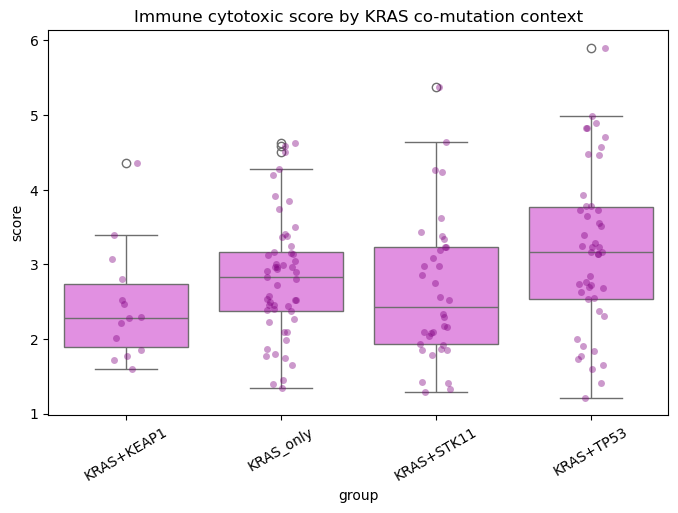

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

sns.boxplot(x="group", y="score", color="violet", data=df)
sns.stripplot(x="group", y="score", data=df, color="purple", alpha=0.4)

plt.title("Immune cytotoxic score by KRAS co-mutation context")
plt.xticks(rotation=30)
plt.savefig("../figures/co-mutation.png", dpi=300, bbox_inches="tight")

plt.show()


In [19]:
from scipy.stats import kruskal

groups_for_test = [
    df[df.group=="KRAS+TP53"].score,
    df[df.group=="KRAS+STK11"].score,
    df[df.group=="KRAS+KEAP1"].score,
    df[df.group=="KRAS_only"].score
]

kruskal(*groups_for_test)

KruskalResult(statistic=9.45835912214477, pvalue=0.023778500645643172)

## Conclusion

KRAS-mutant lung adenocarcinoma samples from TCGA were stratified based on co-occurring mutations in TP53, STK11, and KEAP1. Cytotoxic immune activity was quantified using a canonical CD8 T-cell effector gene signature.

Immune score distributions differed significantly across mutation-context groups (Kruskal–Wallis test, p ≈ 0.024). Tumors harboring KRAS + TP53 mutations showed relatively higher cytotoxic immune activity, while KRAS + STK11 and KRAS + KEAP1 tumors tended to show lower immune scores.

These findings indicate that co-mutation context plays a stronger role in shaping tumor immune activation than KRAS mutation subtype alone. This result is consistent with current understanding of lung cancer immunogenomics and highlights the importance of genetic background when interpreting tumor immunogenicity.

This analysis establishes a mutation-context framework for subsequent investigation of immune gene programs and pathway-level drivers.
